# Part 2 - Other features analysis

The aim of our project is not clearly defined yet. We are hesitating between several topics:
- predict the winner of the 1O0m sprint (or to define)
- predict the winner of the marathon
- have a look on the influence of being in your home country for french athletes at several event in the olympic games; such as surf, climbing, marathon, decathlon. The results of these events might be significantly impacted by the acclamation of the crowd, or the setup of the event can greatly facilitate a french athlete that is use to the meteorological condition...   

In order to do them, our project will be divided in 3 parts:
- a sentiment analysis using sports articles
- a basic neural network machine learning algorithm on past performances/categorical features
- a combination of the 2 above

In this part we are doing the part 2

## ..

#### *100m sprint*

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = "https://worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior"

# Send a request to fetch the page content
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Parse the page content
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table containing the data
table = soup.find('table')

# Extract table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extract table rows
rows = []
for row in table.find_all('tr')[1:]:  # Skip the header row
    columns = row.find_all('td')
    row_data = [col.text.strip() for col in columns]
    rows.append(row_data)

# Create a DataFrame
df = pd.DataFrame(rows, columns=headers)

# Save the data to a CSV file
df.to_csv('100m_sprint_all_time_toplist.csv', index=False)

print("Data has been saved to 100m_sprint_all_time_toplist.csv")


Data has been saved to 100m_sprint_all_time_toplist.csv


In [3]:
df

,Rank,Mark,WIND,Competitor,DOB,Nat,Pos,,Venue,Date,Results Score
0,1,9.58,+0.9,Usain BOLT,21 AUG 1986,JAM,1,,"Olympiastadion, Berlin (GER)",16 AUG 2009,1356
1,2,9.69,+2.0,Tyson GAY,09 AUG 1982,USA,1,,Shanghai (CHN),20 SEP 2009,1316
2,2,9.69,-0.1,Yohan BLAKE,26 DEC 1989,JAM,1,,"Stade Olympique de la Pontaise, Lausanne (SUI)",23 AUG 2012,1316
3,4,9.72,+0.2,Asafa POWELL,23 NOV 1982,JAM,1f1,,"Stade Olympique de la Pontaise, Lausanne (SUI)",02 SEP 2008,1305
4,5,9.74,+0.9,Justin GATLIN,10 FEB 1982,USA,1,,"Suhaim bin Hamad Stadium, Doha (QAT)",15 MAY 2015,1298
...,...,...,...,...,...,...,...,...,...,...,...
95,95,9.94,-0.2,Bernard WILLIAMS,19 JAN 1978,USA,2,,"Commonwealth Stadium, Edmonton (CAN)",05 AUG 2001,1228
96,95,9.94,+1.7,Diondre BATSON,13 JUL 1992,USA,2h2,,"Hayward Field, Eugene, OR (USA)",25 JUN 2015,1227
97,95,9.94,+1.4,Andrew FISHER,15 DEC 1991,JAM,2,,"Moratalaz, Madrid (ESP)",11 JUL 2015,1227
98,95,9.94,+1.0,Ameer WEBB,19 MAR 1991,USA,2f1,,"Stadio Olimpico, Roma (ITA)",02 JUN 2016,1227


We now have created a dataframe and saved it in a csv file. This gives us informations about the 100 first athletes for the 100m sprint in the world.

We have 11 columns:
- ID
- Rank
- Mark
- WIND
- Competitor (the name and surname of the athlete)
- DOB (the date of birth)
- NAT (nationality)
- Pos (I don't know yet)
- Venue (The venue in which he made his best time)
- Date (the date he made his best time)
- Result score

We ideally want to have more information about each individual athlete. To do that, another page of this website has access to their profile page. We need to get access to it doing once again webscrapping.

## Data collection

Web scrapping with *beautifulsoup4* from the website https://worldathletics.org/world-rankings/5000m/men?regionType=world&page=1&rankDate=2024-06-04&limitByCountry=0

#### *5000m*

In [103]:
#pip install requests beautifulsoup4 pandas

Import packages

In [8]:
# Import packages
import json
import csv
import requests
from bs4 import BeautifulSoup

import pandas as pd

Create and define functions

In [85]:
# Function to fetch athlete profile URLs and nationalities
def fetch_profile_urls():
    url = "https://worldathletics.org/world-rankings/5000m/men?regionType=world&page=1&rankDate=2024-06-04&limitByCountry=0"
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all table rows containing athlete data
    athlete_rows = soup.find_all('tr', class_='table-row--hover')

    athletes = {}
    for row in athlete_rows:
        name_element = row.find('td', {'data-th': 'Competitor'})
        if name_element:
            name = name_element.text.strip()
            profile_url = "https://worldathletics.org" + row['data-athlete-url']
            nationality_element = row.find('td', {'data-th': 'Nat'})
            if nationality_element:
                nationality = nationality_element.text.strip()
            else:
                nationality = ""
            athletes[name] = {'profile_url': profile_url, 'nationality': nationality}

    return athletes

In [86]:
# Function to recursively search for 5000 meters results
def search_5000m_results(node, results):
    if isinstance(node, dict):
        for key, value in node.items():
            if isinstance(value, list) or isinstance(value, dict):
                search_5000m_results(value, results)
            elif key == 'discipline' and '5000 Metres' in value:
                results.append(node)
    elif isinstance(node, list):
        for item in node:
            if isinstance(item, list) or isinstance(item, dict):
                search_5000m_results(item, results)


# Function to extract 5000m results for a given athlete URL
def extract_5000m_results(url):
    # Fetch the HTML content of the page
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful
    html_content = response.text

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the <script> tag with id="__NEXT_DATA__" and type="application/json"
    script_tag = soup.find('script', {'id': '__NEXT_DATA__', 'type': 'application/json'})

    # Extract the JSON content from the <script> tag
    json_content = script_tag.string

    # Parse the JSON content
    data = json.loads(json_content)

    # Extract 5000 meters results
    results_5000m = []
    search_5000m_results(data, results_5000m)

    return results_5000m


In [89]:
# Function to extract relevant data
def extract_5000m_data(athlete, nationality, results):
    for result in results:
        # Check if this is a progression result with multiple results
        if 'results' in result:
            for progression in result['results']:
                rows.append({
                    'Athlete': athlete,
                    'Nationality': nationality,
                    'Score': progression.get('resultScore', ''),
                    'Date': progression.get('date', ''),
                    'Venue': progression.get('venue', ''),
                    'Place': progression.get('place', '')  # Use 'listPosition' instead of 'place'
                })
        else:
            rows.append({
                'Athlete': athlete,
                'Nationality': nationality,
                'Score': result.get('resultScore', ''),
                'Date': result.get('date', ''),
                'Venue': result.get('venue', ''),
                'Place': result.get('place', '')  # Use 'listPosition' instead of 'place'
            })

Create a dataset in a data frame and csv format.

In [90]:
# Fetch athlete profile URLs
athletes = fetch_profile_urls()

# List to hold all extracted rows
all_rows = []

# Loop through each athlete and extract their 5000m results
for athlete, data in athletes.items():
    athlete_url = data['profile_url']
    nationality = data['nationality']
    #print(f"Extracting 5000m results for {athlete}...")
    athlete_results = extract_5000m_results(athlete_url)
    
    # List to hold the extracted rows for this athlete
    rows = []
    # Extract data for this athlete
    extract_5000m_data(athlete, nationality, athlete_results)
    # Add rows for this athlete to the list of all rows
    all_rows.extend(rows)

# Define CSV file name
csv_file_name = '5000m_results_with_urls.csv'

# Write all rows to CSV
with open(csv_file_name, 'w', newline='') as csv_file:
    fieldnames = ['Athlete', 'Nationality', 'Score', 'Date', 'Venue', 'Place']  # Add 'Athlete' field
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for row in all_rows:
        writer.writerow(row)

print(f"Data successfully written to {csv_file_name}")

Extracting 5000m results for Yomif KEJELCHA...
Extracting 5000m results for Hagos GEBRHIWET...
Extracting 5000m results for Berihu AREGAWI...
Extracting 5000m results for Telahun Haile BEKELE...
Extracting 5000m results for Jakob INGEBRIGTSEN...
Extracting 5000m results for Jacob KIPLIMO...
Extracting 5000m results for Selemon BAREGA...
Extracting 5000m results for Grant FISHER...
Extracting 5000m results for Luis GRIJALVA...
Extracting 5000m results for Joshua CHEPTEGEI...
Extracting 5000m results for Dominic Lokinyomo LOBALU...
Extracting 5000m results for Biniam MEHARY...
Extracting 5000m results for Thierry NDIKUMWENAYO...
Extracting 5000m results for Nicholas KIPKORIR...
Extracting 5000m results for Jacob KROP...
Extracting 5000m results for Birhanu BALEW...
Extracting 5000m results for Samuel TEFERA...
Extracting 5000m results for Andreas ALMGREN...
Extracting 5000m results for Kuma GIRMA...
Extracting 5000m results for Addisu YIHUNE...
Extracting 5000m results for Mohammed AHMED

## Preprocessing the data

In [91]:
df_5000m = pd.read_csv(csv_file_name)
df_5000m.head()

,Athlete,Nationality,Score,Date,Venue,Place
0,Yomif KEJELCHA,ETH,1288.0,30 MAY 2024,"Bislett Stadion, Oslo (NOR)",NaN
1,Yomif KEJELCHA,ETH,1288.0,30 MAY 2024,"Bislett Stadion, Oslo (NOR)",NaN
2,Yomif KEJELCHA,ETH,1119.0,25 JUL 2014,"Hayward Field, Eugene, OR (USA)",NaN
3,Yomif KEJELCHA,ETH,1232.0,11 SEP 2015,"Boudewijnstadion, Bruxelles (BEL)",NaN
4,Yomif KEJELCHA,ETH,1198.0,14 MAY 2016,"Shanghai Stadium, Shanghai (CHN)",NaN


In [93]:
df_5000m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3940 entries, 0 to 3939
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Athlete      3940 non-null   object 
 1   Nationality  3940 non-null   object 
 2   Score        1624 non-null   float64
 3   Date         2852 non-null   object 
 4   Venue        2852 non-null   object 
 5   Place        1450 non-null   float64
dtypes: float64(2), object(4)
memory usage: 184.8+ KB


In [94]:
# Counting null values per column
null_counts = df_5000m.isnull().sum()
print("Number of null values per column:")
print(null_counts)


Number of null values per column:
Athlete           0
Nationality       0
Score          2316
Date           1088
Venue          1088
Place          2490
dtype: int64


In [95]:
# Removing rows with null 'Venue' & removing duplicates
df_5000m_cleaned0 = df_5000m.dropna(subset=['Venue'])
df_5000m_cleaned1 = df_5000m_cleaned0.drop_duplicates()
df_5000m_cleaned2 = df_5000m_cleaned1.dropna(subset=['Place', 'Score'], how='all')


In [99]:
null_counts = df_5000m_cleaned2.isnull().sum()
print("Number of null values per column:")
print(null_counts)

Number of null values per column:
Athlete          0
Nationality      0
Score          476
Date             0
Venue            0
Place          793
dtype: int64


Now that we have removed all of the rows with NA venue, and all of the rows where either `place`, `score` or both were empty, we need to assign the right type for each variable.

The 5 differents variables are: 
- Athlete: object into character or factor
- Score: float
- Data: object to convert into datetime
- Venue: object into character or factor or to dertermine
- Place: float to convert into nummerical

In [102]:
df = df_5000m_cleaned2
df.loc[:, 'Athlete'] = pd.Categorical(df['Athlete'])
df.loc[:, 'Nationality'] = pd.Categorical(df['Nationality'])
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format='%d %b %Y', errors='coerce')
print(df)

               Athlete Nationality   Score                 Date  \
0       Yomif KEJELCHA         ETH  1288.0  2024-05-30 00:00:00   
2       Yomif KEJELCHA         ETH  1119.0  2014-07-25 00:00:00   
3       Yomif KEJELCHA         ETH  1232.0  2015-09-11 00:00:00   
4       Yomif KEJELCHA         ETH  1198.0  2016-05-14 00:00:00   
5       Yomif KEJELCHA         ETH  1205.0  2017-05-27 00:00:00   
...                ...         ...     ...                  ...   
3923  Merhawi MEBRAHTU         ERI  1065.0  2021-08-19 00:00:00   
3925  Merhawi MEBRAHTU         ERI  1170.0  2023-07-15 00:00:00   
3926  Merhawi MEBRAHTU         ERI     NaN  2022-08-01 00:00:00   
3927  Merhawi MEBRAHTU         ERI     NaN  2021-08-19 00:00:00   
3928  Merhawi MEBRAHTU         ERI     NaN  2022-07-21 00:00:00   

                                                  Venue  Place  
0                           Bislett Stadion, Oslo (NOR)    NaN  
2                       Hayward Field, Eugene, OR (USA)    NaN  


In [104]:
df['Nationality'].value_counts()

Nationality
ETH    157
USA    156
AUS    113
NOR    103
GER     95
FRA     91
KEN     82
ESP     75
GBR     75
CAN     71
UGA     59
SUI     46
BEL     42
JPN     41
NED     39
IRL     34
SWE     27
BRN     25
ITA     21
RUS     21
GUA     19
BDI     17
SRB     17
RSA     15
THA     15
ERI     13
AUT     13
DJI      9
IND      9
URU      8
MAR      5
Name: count, dtype: int64

### Data simulation

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of simulations
num_simulations = 10000

# Define the nationalities and the number of athletes for each
nationalities = {
    'ETH': 157, 'USA': 156, 'AUS': 113, 'NOR': 103, 'GER': 95, 'FRA': 91, 
    'KEN': 82, 'ESP': 75, 'GBR': 75, 'CAN': 71, 'UGA': 59, 'SUI': 46, 
    'BEL': 42, 'JPN': 41, 'NED': 39, 'IRL': 34, 'SWE': 27, 'BRN': 25, 
    'ITA': 21, 'RUS': 21, 'GUA': 19, 'BDI': 17, 'SRB': 17, 'RSA': 15, 
    'THA': 15, 'ERI': 13, 'AUT': 13, 'DJI': 9, 'IND': 9, 'URU': 8, 'MAR': 5
}

# Define distances (in some normalized form) from France for each country
distance_factor = {
    'ETH': 0.5, 'USA': 0.7, 'AUS': 0.9, 'NOR': 0.2, 'GER': 0.1, 'FRA': 0.0, 
    'KEN': 0.5, 'ESP': 0.1, 'GBR': 0.1, 'CAN': 0.6, 'UGA': 0.5, 'SUI': 0.1, 
    'BEL': 0.1, 'JPN': 0.8, 'NED': 0.1, 'IRL': 0.2, 'SWE': 0.2, 'BRN': 0.7, 
    'ITA': 0.1, 'RUS': 0.4, 'GUA': 0.8, 'BDI': 0.5, 'SRB': 0.3, 'RSA': 0.6, 
    'THA': 0.8, 'ERI': 0.5, 'AUT': 0.1, 'DJI': 0.6, 'IND': 0.7, 'URU': 0.8, 'MAR': 0.2
}

# Define climate similarity factor (1.0 means very similar, 0.0 means very different)
climate_factor = {
    'ETH': 0.4, 'USA': 0.6, 'AUS': 0.6, 'NOR': 0.7, 'GER': 0.9, 'FRA': 1.0, 
    'KEN': 0.4, 'ESP': 0.8, 'GBR': 0.8, 'CAN': 0.6, 'UGA': 0.4, 'SUI': 0.9, 
    'BEL': 0.8, 'JPN': 0.6, 'NED': 0.8, 'IRL': 0.8, 'SWE': 0.7, 'BRN': 0.4, 
    'ITA': 0.9, 'RUS': 0.6, 'GUA': 0.3, 'BDI': 0.4, 'SRB': 0.7, 'RSA': 0.5, 
    'THA': 0.3, 'ERI': 0.4, 'AUT': 0.9, 'DJI': 0.4, 'IND': 0.4, 'URU': 0.4, 'MAR': 0.8
}

# Define cultural/travel ease factor (1.0 means very easy, 0.0 means very hard)
cultural_factor = {
    'ETH': 0.4, 'USA': 0.7, 'AUS': 0.6, 'NOR': 0.8, 'GER': 0.9, 'FRA': 1.0, 
    'KEN': 0.4, 'ESP': 0.9, 'GBR': 0.9, 'CAN': 0.7, 'UGA': 0.4, 'SUI': 0.9, 
    'BEL': 0.9, 'JPN': 0.6, 'NED': 0.9, 'IRL': 0.8, 'SWE': 0.8, 'BRN': 0.4, 
    'ITA': 0.9, 'RUS': 0.6, 'GUA': 0.3, 'BDI': 0.4, 'SRB': 0.7, 'RSA': 0.4, 
    'THA': 0.3, 'ERI': 0.4, 'AUT': 0.9, 'DJI': 0.3, 'IND': 0.3, 'URU': 0.3, 'MAR': 0.8
}

# Function to calculate mean and standard deviation based on factors
def calculate_params(distance, climate, cultural):
    base_mean = 0.10
    base_std = 0.05
    mean_cheering_effect = base_mean + 0.05 * (1 - distance) + 0.05 * cultural
    std_cheering_effect = base_std - 0.01 * cultural
    
    mean_environmental_adaptation = base_mean + 0.05 * climate
    std_environmental_adaptation = base_std - 0.01 * climate
    
    return mean_cheering_effect, std_cheering_effect, mean_environmental_adaptation, std_environmental_adaptation

# Create the params dictionary
params = {}
for nationality in nationalities.keys():
    mean_cheering_effect, std_cheering_effect, mean_environmental_adaptation, std_environmental_adaptation = calculate_params(
        distance_factor[nationality], climate_factor[nationality], cultural_factor[nationality]
    )
    params[nationality] = {
        'mean_cheering_effect': mean_cheering_effect, 'std_cheering_effect': std_cheering_effect,
        'mean_environmental_adaptation': mean_environmental_adaptation, 'std_environmental_adaptation': std_environmental_adaptation
    }

In [122]:
# Assuming your existing DataFrame is named df and has a column 'Nationality'

# Function to simulate performance for a given nationality
def simulate_performance(nationality, num_athletes):
    mean_cheering_effect = params[nationality]['mean_cheering_effect']
    std_cheering_effect = params[nationality]['std_cheering_effect']
    mean_environmental_adaptation = params[nationality]['mean_environmental_adaptation']
    std_environmental_adaptation = params[nationality]['std_environmental_adaptation']
    
    cheering_effect = np.random.normal(mean_cheering_effect, std_cheering_effect, num_athletes)
    environmental_adaptation = np.random.normal(mean_environmental_adaptation, std_environmental_adaptation, num_athletes)
    performance = cheering_effect + environmental_adaptation
    
    return cheering_effect, environmental_adaptation, performance

# Initialize lists to store simulated results
cheering_effects = []
environmental_adaptations = []
performances = []

# Iterate through each unique nationality in the DataFrame
for nationality in df['Nationality'].unique():
    num_athletes = nationalities[nationality]  # Number of athletes for this nationality
    cheering_effect, environmental_adaptation, performance = simulate_performance(nationality, num_athletes)
    
    # Extend lists with simulation results
    cheering_effects.extend(cheering_effect)
    environmental_adaptations.extend(environmental_adaptation)
    performances.extend(performance)

# Assign simulated results to DataFrame using .loc to avoid SettingWithCopyWarning
df.loc[:, 'CrowdCheeringEffect'] = cheering_effects
df.loc[:, 'EnvironmentalAdaptation'] = environmental_adaptations
df.loc[:, 'OverallPerformance'] = performances

# Print the updated DataFrame
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1513 entries, 0 to 3928
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Athlete                  1513 non-null   object 
 1   Nationality              1513 non-null   object 
 2   Score                    1037 non-null   float64
 3   Date                     1513 non-null   object 
 4   Venue                    1513 non-null   object 
 5   Place                    720 non-null    float64
 6   cheering_effect          1513 non-null   float64
 7   CrowdCheeringEffect      1513 non-null   float64
 8   EnvironmentalAdaptation  1513 non-null   float64
 9   OverallPerformance       1513 non-null   float64
dtypes: float64(6), object(4)
memory usage: 130.0+ KB
None


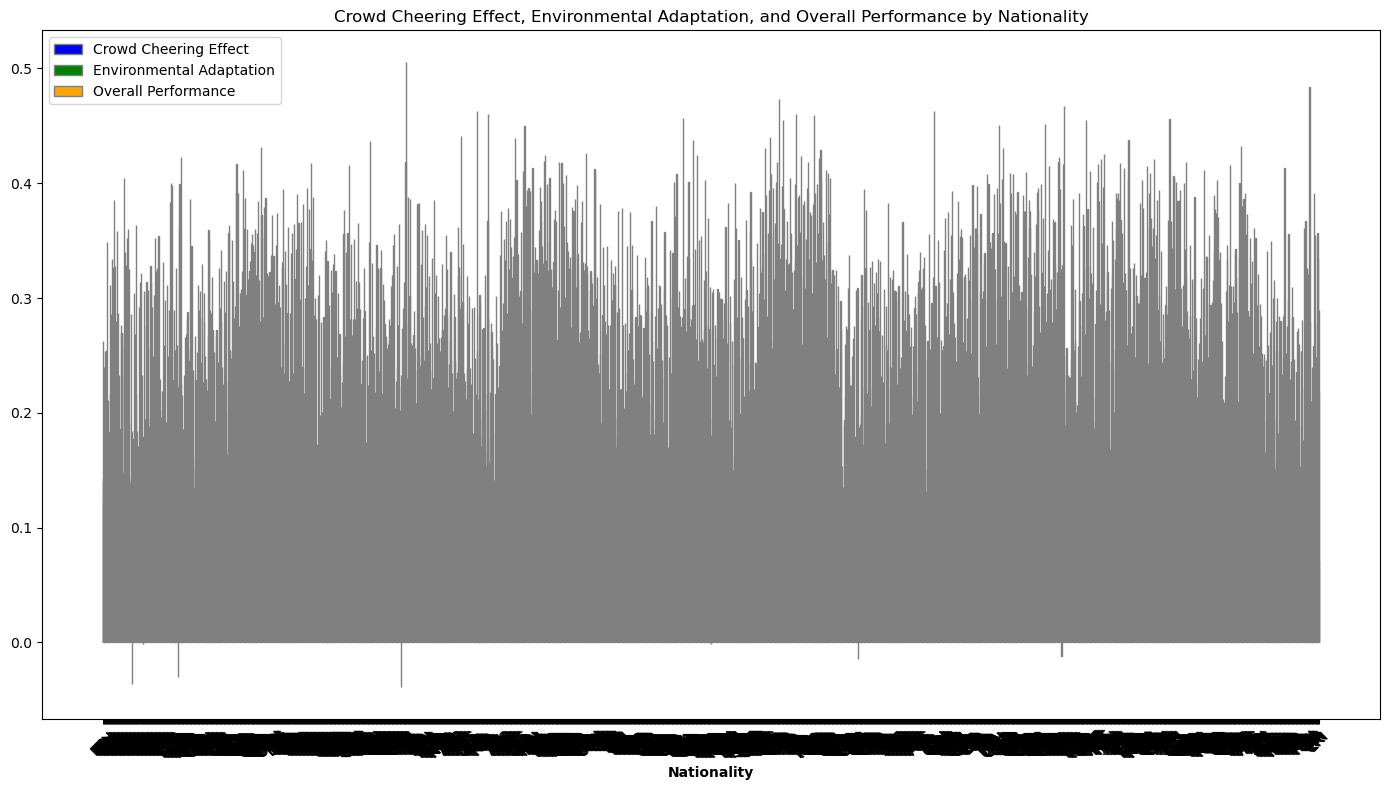

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of nationalities
num_nationalities = len(df)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Set width of bars
bar_width = 0.2

# Set position of bar on X axis
r1 = np.arange(num_nationalities)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot bars
ax.bar(r1, df['CrowdCheeringEffect'], color='blue', width=bar_width, edgecolor='grey', label='Crowd Cheering Effect')
ax.bar(r2, df['EnvironmentalAdaptation'], color='green', width=bar_width, edgecolor='grey', label='Environmental Adaptation')
ax.bar(r3, df['OverallPerformance'], color='orange', width=bar_width, edgecolor='grey', label='Overall Performance')

# Add xticks on the middle of the group bars
plt.xlabel('Nationality', fontweight='bold')
plt.xticks([r + bar_width for r in range(num_nationalities)], df['Nationality'], rotation=45)

# Create legend & Show graphic
ax.legend()
plt.title('Crowd Cheering Effect, Environmental Adaptation, and Overall Performance by Nationality')
plt.tight_layout()
plt.show()
